In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [46]:
option_data = pd.read_csv("option_data.csv")
S_data = pd.read_csv("price_data.csv")

C:\Users\yigaa\AppData\Local\Temp\ipykernel_7364\1663855361.py:1: DtypeWarning: Columns (23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  option_data = pd.read_csv("option_data.csv")


In [47]:
#option_data = pd.read_csv("option_price_SP500.csv")

In [48]:
#S_data = pd.read_csv("underlying_asset_SP500.csv")

In [49]:
option_data.columns

Index(['secid', 'date', 'symbol', 'symbol_flag', 'exdate', 'last_date',
       'cp_flag', 'strike_price', 'best_bid', 'best_offer', 'volume',
       'open_interest', 'impl_volatility', 'delta', 'gamma', 'vega', 'theta',
       'optionid', 'cfadj', 'am_settlement', 'contract_size', 'ss_flag',
       'forward_price', 'expiry_indicator', 'root', 'suffix', 'cusip',
       'ticker', 'sic', 'index_flag', 'exchange_d', 'class', 'issue_type',
       'industry_group', 'issuer', 'div_convention', 'exercise_style',
       'am_set_flag'],
      dtype='object')

In [50]:
# option_data = option_data.iloc[:100000]
# S_data = S_data.iloc[:100000]

secid: 证券唯一标识符。108105代表S&P500
**date**: 数据记录的日期。  
symbol: 期权或相关资产的标识符。
symbol_flag: 标识符的标记，指示其特定状态。
**exdate**: 期权的到期日期。  
last_date: 最后交易日期。
**cp_flag**: 表示期权类型（看涨或看跌）。"C" "P"  
**strike_price**: 行权价格。

**best_bid**: 期权的最佳买入报价。  
**best_offer**: 期权的最佳卖出报价。  
算期权价格？  

volume: 交易量。
open_interest: 未平仓合约数。  
希腊值
**impl_volatility**: 隐含波动率，反映市场对期权价格波动的预期。
**delta**: 衡量期权价格对基础资产价格变动的敏感度。
**gamma**: 衡量delta的变化率。
**vega**: 衡量期权价格对隐含波动率变化的敏感度。
**theta**: 衡量期权价格随时间流逝的变化。  
optionid: 期权的唯一标识符。
cfadj: 现金流调整标识。
am_settlement: 是否为自动行权结算。
contract_size: 合约规模。
ss_flag: 标识某些特定的属性。
forward_price: 远期价格。
expiry_indicator: 是否接近到期的标识。
root: 期权根符号。
suffix: 额外的标识后缀。
cusip: 证券统一标识代码。
ticker: 交易所代码。
sic: 行业分类代码。
index_flag: 指示是否为指数期权。
exchange_d: 交易所信息。
class: 期权类别。 
issue_type: 发行类型。
industry_group: 行业组别。
issuer: 发行方。
div_convention: 分红惯例。
**exercise_style**: 行权方式（美式或欧式）。American Europe 
am_set_flag: 自动行权标识。

In [51]:
option_data = option_data[["date","symbol","exdate","cp_flag","best_bid","best_offer","strike_price","impl_volatility","delta","gamma","vega","theta","exercise_style"]]

# data
price of underlying asset and type of option: S
- S&P 500: E 收盘价？ normalized?多一天？  
- S&P 100: E+A
- DJIA/DJX: E
- the individual stocks underlying the DJIA: A
- ETF(gold (GLD), silver (SLV) and oil (USO), Barclays U.S. 20+ year Treasury Bond Index (TLT), e Barclays U.S. 7–10 year Treasury Bond Index (IEF)): A

time period
January 2, 2004–August 31, 2015, except for the commodity ETFs
where data was first available in 2008

select
- Options with remaining lives less than 14 days were removed from the data set(deal when getting data)
- Call options for which the practitioner Black-Scholes delta was less than 0.05 or greater than 0.95, and put options for which the practitioner Black-Scholes delta was less than –0.95 or greater than –0.05 were
removed from the data set.   

bid price, offer price, implied, volatility, delta, gamma, vega, and theta(practitioner Black–Scholes model)

moneyness：$\delta_{BS}$: rouning to nearest 10  
time to maturity: exdate, date: seven different option maturity buckets (14–30 days, 31–
60 days, 61–91 days, 92–122 days, 123–182 days, 183–365 days,
and more than 365 days  
price of option: best_bid? best_ask? mid ask?



# group
for $\delta_{MV}$  
$\delta_{BS}$, maturity bucket, put call  

# window
36-month

# 数据预处理

bid price, offer price, implied, volatility, delta, gamma, vega, and theta不缺失

In [52]:
option_data = option_data.dropna(subset=["best_bid", "best_offer", "impl_volatility", "delta", "gamma", "vega","theta"])

Call options for which the practitioner Black-Scholes delta was less than 0.05 or greater than 0.95, and put options for which the practitioner Black-Scholes delta was less than –0.95 or greater than –0.05 were removed from the data set.

In [53]:
option_data = option_data.query("(cp_flag=='C' & 0.95>delta>0.05)|(cp_flag=='P' & -0.05>delta>-0.95)")

f取best_bid,best_ask的平均？S normalized?
1 DAY CHANGE?

In [54]:
option_data["f_t"] = option_data.eval("(best_bid+best_offer)/2")

In [55]:
option_data = option_data.merge(pd.pivot(option_data,columns="symbol",index="date",values="f_t").shift(1).stack().reset_index(),on=["date","symbol"],how="left")

In [56]:
l = list(option_data.columns.copy())
l[-1] = "f_t_minus_1"

In [57]:
option_data.columns = l

In [58]:
S_data['S_t'] = S_data["close"]#.pct_change()+1
S_data['S_t_minus_1'] = S_data.shift(1)['close']

给option配上原生资产价格

In [59]:
data = option_data.merge(S_data[["date","S_t",'S_t_minus_1']],on=["date"],how="left")[["date","symbol","exdate","cp_flag","exercise_style","S_t",'S_t_minus_1',"f_t_minus_1","f_t","delta","gamma","vega","theta","strike_price"]]

# 计算

In [60]:
data.dropna(inplace=True)

time to maturity

In [61]:
data.date = pd.to_datetime(data.date)
data.exdate = pd.to_datetime(data.exdate)
data['maturity'] = (data.exdate - data.date).dt.days/365

\delta_BS四舍五入

In [62]:
maturity_bucket = np.array([30,60,91,122,182,365])/365

In [63]:
data['maturity_group'] = data['maturity'].apply(lambda x: np.sum(x > maturity_bucket))
data['delta_group'] = round(data['delta']*10)/10#0.05四舍五入
data['month'] = data['date'].dt.month
data['ym'] = data.date.astype(str).str[0:7]

计算historical delta（也许不需要）

In [64]:
# def f_delta(df):
#     window = 36#M
#     pivot_df = pd.pivot(df,values="delta",index="date",columns="symbol")
#     reset_pivot_df = pivot_df.reset_index()
#     reset_pivot_df['ym'] = reset_pivot_df.date.astype(str).str[0:7]
#     return reset_pivot_df.groupby("ym").apply(lambda x:pivot_df[((x.date.iloc[0] - pd.DateOffset(months=window)).replace(day=1)):((x.date.iloc[0]).replace(day=1)- pd.DateOffset(days=1))].mean().mean())
#     
# result = data.groupby(["maturity_group","delta_group","exercise_style","cp_flag"]).apply(f_delta)

In [65]:
# result.reset_index()

In [66]:
 #data['ym'] = data.date.astype(str).str[0:7]
# data["delta"] = data.merge(result.reset_index(),on=["maturity_group","delta_group","exercise_style","cp_flag","ym"])[0]

计算historical vega（也许不需要）

In [67]:
# def f_vega(df):
#     window = 36#M
#     pivot_df = pd.pivot(df,values="vega",index="date",columns="symbol")
#     reset_pivot_df = pivot_df.reset_index()
#     reset_pivot_df['ym'] = reset_pivot_df.date.astype(str).str[0:7]
#     return reset_pivot_df.groupby("ym").apply(lambda x:pivot_df[((x.date.iloc[0] - pd.DateOffset(months=window)).replace(day=1)):((x.date.iloc[0]).replace(day=1)- pd.DateOffset(days=1))].mean().mean())
#     
# result2 = data.groupby(["maturity_group","delta_group","exercise_style","cp_flag"]).apply(f_vega)

In [68]:
# data["historical_vega"] = data.merge(result.reset_index(),on=["maturity_group","delta_group","exercise_style","cp_flag","ym"])[0]

# 计算abc

linear_regression
不设截距项

In [69]:
(data["vega"]/ ((data["maturity"])**0.5*data["S_t"]/data["S_t_minus_1"]))*(data["S_t"]/data["S_t_minus_1"]-1)

327        1.131908
328        3.405424
329        2.518509
330        1.526468
331        1.968666
             ...   
2974931   -4.870188
2974932   -4.023551
2974933   -3.129895
2974934   -2.360082
2974935   -1.554957
Length: 2852937, dtype: float64

In [70]:
from sklearn.linear_model import LinearRegression
def f_regression(x,df,window):
    #window = 1#单位：月
    #计算上36个月开始日期和结束日期
    start_date = (x.date.iloc[0] - pd.DateOffset(months=window)).replace(day=1)#36个月前第一天
    end_date = (x.date.iloc[0]).replace(day=1)- pd.DateOffset(days=1)#上个月最后一天

    loc_df = df[(df.date>=start_date) & (df.date<=end_date) & (df.cp == x.cp.iloc[0])]
    #创建特征123+target
    X = loc_df["coeffi"].to_frame()
    X["coeffi2"] = X["coeffi"]*(loc_df["delta"])
    X["coeffi3"] = X["coeffi2"]*(loc_df["delta"])
    X["target"] = loc_df["f_t"] / loc_df["f_t_minus_1"] -1 - loc_df["delta"]*(loc_df["S_t"]/loc_df["S_t_minus_1"]-1)
    df["coeffi2"] = df["coeffi"]*(df["delta"])
    df["coeffi3"] = df["coeffi2"]*(df["delta"])
    df["target"] = df["f_t"] / df["f_t_minus_1"] -1 - df["delta"]*(df["S_t"]/df["S_t_minus_1"]-1)
    #normalized?不然截距项可能不太是0？
    #X["target"] = loc_df["f_t"] - loc_df["f_t_minus_1"] - loc_df["delta"]*(loc_df["S_t"]-loc_df["S_t_minus_1"])
    X.dropna(inplace=True)
    y = X['target']
    X.drop('target',inplace=True,axis=1)
    if len(X)>0:#判断是否有数据可以计算
        model = LinearRegression(fit_intercept=False)#去掉截距项？
        model.fit(X, y)
        df.loc[x.index,["a","b","c"]] = model.coef_     
        return model.coef_
    else:
        return np.nan
    
def f_abc(df):
    window = 36#单位：月
    df["coeffi"] = (df["vega"]/ ((df["maturity"])**0.5*df["S_t"]/df["S_t_minus_1"]))*(df["S_t"]/df["S_t_minus_1"]-1)#normalized S_t_minus_1 = 1?
    #df["coeffi"] = (df["vega"]/ ((df["maturity"])**0.5*df["S_t"]))*(df["S_t"]-df["S_t_minus_1"])
    #df['ym'] = df.date.astype(str).str[0:7]
    df[["a","b","c"]] = np.nan
    df["cp"] = df["cp_flag"]
    return df.groupby(["ym","cp_flag"]).apply(f_regression,df,window)#reset_pivot_df.groupby("ym").apply(lambda x:pivot_df[((x.date.iloc[0] - pd.DateOffset(months=window)).replace(day=1)):((x.date.iloc[0]).replace(day=1)- pd.DateOffset(days=1))].mean().mean())
f_abc(data)

C:\Users\yigaa\AppData\Local\Temp\ipykernel_7364\1258757262.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(["ym","cp_flag"]).apply(f_regression,df,window)#reset_pivot_df.groupby("ym").apply(lambda x:pivot_df[((x.date.iloc[0] - pd.DateOffset(months=window)).replace(day=1)):((x.date.iloc[0]).replace(day=1)- pd.DateOffset(days=1))].mean().mean())


ym       cp_flag
2004-01  C                                                        NaN
         P                                                        NaN
2004-02  C          [0.08247147889664996, -0.18251442504536994, 0....
         P          [-0.0968954272371367, -0.24841567622074737, -0...
2004-03  C          [0.08236337952527414, -0.1816502345663808, 0.1...
                                          ...                        
2015-06  P          [-0.0881818844017201, -0.2374935572283707, -0....
2015-07  C          [0.08756522653621514, -0.20807940455516355, 0....
         P          [-0.08915480737511217, -0.23942288354758445, -...
2015-08  C          [0.085756715882616, -0.20342958761436958, 0.14...
         P          [-0.08991154745206299, -0.24191024051882176, -...
Length: 280, dtype: object

In [71]:
data.query("cp_flag=='P'&symbol=='SXB.RJ'").sort_values("date")

,date,symbol,exdate,cp_flag,exercise_style,S_t,S_t_minus_1,f_t_minus_1,f_t,delta,...,month,ym,coeffi,a,b,c,cp,coeffi2,coeffi3,target
510,2004-01-05,SXB.RJ,2004-06-19,P,E,1122.22,1108.48,11.30,9.60,-0.113632,...,1,2004-01,2.630043,NaN,NaN,NaN,P,-0.298857,0.033960,-0.149034
777,2004-01-06,SXB.RJ,2004-06-19,P,E,1123.67,1122.22,9.60,8.10,-0.102666,...,1,2004-01,0.258049,NaN,NaN,NaN,P,-0.026493,0.002720,-0.156117
1040,2004-01-07,SXB.RJ,2004-06-19,P,E,1126.33,1123.67,8.10,7.30,-0.095394,...,1,2004-01,0.448761,NaN,NaN,NaN,P,-0.042809,0.004084,-0.098540
1303,2004-01-08,SXB.RJ,2004-06-19,P,E,1131.92,1126.33,7.30,6.30,-0.086026,...,1,2004-01,0.873135,NaN,NaN,NaN,P,-0.075112,0.006462,-0.136559
1571,2004-01-09,SXB.RJ,2004-06-19,P,E,1121.86,1131.92,6.30,7.80,-0.101193,...,1,2004-01,-1.771719,NaN,NaN,NaN,P,0.179286,-0.018142,0.237196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835930,2010-02-05,SXB.RJ,2010-06-19,P,E,1066.19,1063.11,26.70,26.55,-0.232949,...,2,2010-02,0.934398,-0.070429,-0.183261,-0.148537,P,-0.217667,0.050705,-0.004943
836764,2010-02-08,SXB.RJ,2010-06-19,P,E,1056.74,1066.19,26.55,28.50,-0.246854,...,2,2010-02,-2.960782,-0.070429,-0.183261,-0.148537,P,0.730881,-0.180421,0.071258
837575,2010-02-09,SXB.RJ,2010-06-19,P,E,1070.52,1056.74,28.50,24.95,-0.223499,...,2,2010-02,4.084816,-0.070429,-0.183261,-0.148537,P,-0.912952,0.204044,-0.121647
838399,2010-02-10,SXB.RJ,2010-06-19,P,E,1068.13,1070.52,24.95,24.95,-0.224562,...,2,2010-02,-0.710829,-0.070429,-0.183261,-0.148537,P,0.159625,-0.035846,-0.000501


<Axes: xlabel='date'>

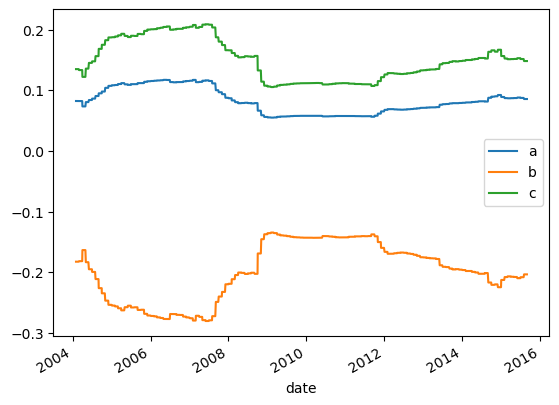

In [72]:
data.query("cp_flag=='C'")[["date","a","b","c"]].drop_duplicates("date").set_index("date").plot()

<Axes: xlabel='date'>

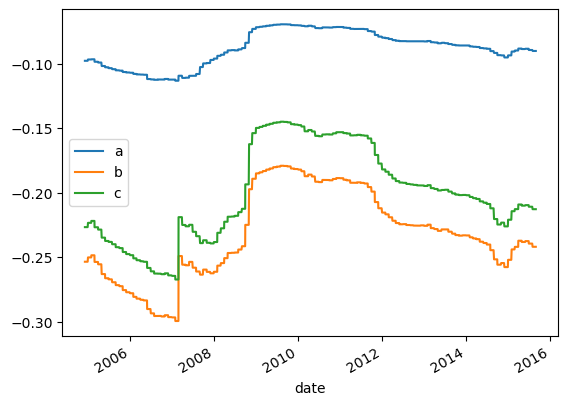

In [73]:
data.query("cp_flag=='P' & '2004-12-06'<date<'2015-12-14'")[["date","a","b","c"]].drop_duplicates("date").set_index("date").plot()

$$\delta_{MV} = \delta_{BS} + \frac{\nu_{BS}}{S\sqrt{T}}(a+b\delta_{BS}+c\delta_{BS}^2)$$

# 对冲

In [74]:
def f_MV_delta(data):
    return data["delta"] + (data["vega"]/ ((data["maturity"])**0.5*data["S_t"]/data["S_t_minus_1"]))*(data["a"]+data["b"]*data["delta"]+data["c"]*data["delta"]*data["delta"])
data["MV_delta"] = f_MV_delta(data)

In [75]:
(data["MV_delta"]-data["delta"]).max()

31.687391208844833

# 误差

$$ 
\epsilon_{MV} = \Delta f - \delta_{MV}\Delta S
$$

$$\epsilon_{BS} = \Delta f - \delta_{BS}\Delta S$$ 

In [76]:
(data["MV_delta"]-data["delta"]).sum()

-6628493.551601449

In [77]:
SSE_MV = data.groupby(["maturity_group","delta_group","exercise_style","cp_flag","ym"]).apply(lambda x:((x["f_t"]-x["f_t_minus_1"] - x["MV_delta"]*(x["S_t"]-x["S_t_minus_1"]))**2).sum()).reset_index()

C:\Users\yigaa\AppData\Local\Temp\ipykernel_7364\1312441515.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  SSE_MV = data.groupby(["maturity_group","delta_group","exercise_style","cp_flag","ym"]).apply(lambda x:((x["f_t"]-x["f_t_minus_1"] - x["MV_delta"]*(x["S_t"]-x["S_t_minus_1"]))**2).sum()).reset_index()


In [78]:
SSE_BS = data.groupby(["maturity_group","delta_group","exercise_style","cp_flag","ym"]).apply(lambda x:((x["f_t"]-x["f_t_minus_1"] - x["delta"]*(x["S_t"]-x["S_t_minus_1"]))**2).sum()).reset_index()

C:\Users\yigaa\AppData\Local\Temp\ipykernel_7364\4125830344.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  SSE_BS = data.groupby(["maturity_group","delta_group","exercise_style","cp_flag","ym"]).apply(lambda x:((x["f_t"]-x["f_t_minus_1"] - x["delta"]*(x["S_t"]-x["S_t_minus_1"]))**2).sum()).reset_index()


$$GAIN = \frac{\epsilon_{BS}-\epsilon_{MV}}{\epsilon_{BS}} =  1-\frac{\epsilon_{MV}}{\epsilon_{BS}}$$

In [79]:
SSE = SSE_MV.merge(SSE_BS,on=['maturity_group', 'delta_group', 'exercise_style', 'cp_flag', 'ym'])
SSE.columns = ['maturity_group', 'delta_group', 'exercise_style', 'cp_flag', 'ym']+["SSE_MV","SSE_BS"]

In [80]:
SSE["GAIN"] = 1 - SSE["SSE_MV"]/SSE["SSE_BS"]

In [81]:
SSE["SSE_MV"]

0        0.000000e+00
1        2.722293e+05
2        3.009401e+05
3        2.306800e+05
4        2.486744e+05
             ...     
17397    4.906940e+06
17398    7.971357e+06
17399    8.917954e+06
17400    9.113319e+06
17401    4.673306e+07
Name: SSE_MV, Length: 17402, dtype: float64

In [82]:
SSE["SSE_BS"]

0          112.897673
1           70.749419
2          148.408334
3           71.082628
4          298.786672
             ...     
17397     5908.043659
17398     3167.481810
17399     3761.060447
17400     3308.638147
17401    14666.224864
Name: SSE_BS, Length: 17402, dtype: float64

In [83]:
SSE

,maturity_group,delta_group,exercise_style,cp_flag,ym,SSE_MV,SSE_BS,GAIN
0,0,-0.9,E,P,2004-01,0.000000e+00,112.897673,1.000000
1,0,-0.9,E,P,2004-02,2.722293e+05,70.749419,-3846.795362
2,0,-0.9,E,P,2004-03,3.009401e+05,148.408334,-2026.784573
3,0,-0.9,E,P,2004-04,2.306800e+05,71.082628,-3244.236790
4,0,-0.9,E,P,2004-05,2.486744e+05,298.786672,-831.280616
...,...,...,...,...,...,...,...,...
17397,6,0.9,E,C,2015-04,4.906940e+06,5908.043659,-829.552490
17398,6,0.9,E,C,2015-05,7.971357e+06,3167.481810,-2515.622899
17399,6,0.9,E,C,2015-06,8.917954e+06,3761.060447,-2370.127592
17400,6,0.9,E,C,2015-07,9.113319e+06,3308.638147,-2753.401818


In [84]:
SSE[SSE.ym.str[0:4].astype(int)>=2007].groupby(["cp_flag","delta_group"])["GAIN"].mean()

cp_flag  delta_group
C         0.1          -96093.868827
          0.2          -61908.461066
          0.3          -33845.171002
          0.4          -17919.765559
          0.5           -9336.121686
          0.6           -5578.832906
          0.7           -4188.751264
          0.8           -3765.143422
          0.9           -2402.680369
P        -0.9           -8196.676788
         -0.8          -10712.007463
         -0.7           -9346.393562
         -0.6           -8766.892980
         -0.5          -11232.424023
         -0.4          -18491.093979
         -0.3          -33857.613567
         -0.2          -59553.742841
         -0.1          -86968.832140
Name: GAIN, dtype: float64

In [85]:
SSE.groupby(["cp_flag"])["GAIN"].mean()

cp_flag
C   -26564.841850
P   -27738.853725
Name: GAIN, dtype: float64

In [86]:
SSE.groupby(["cp_flag","delta_group"])["GAIN"].mean()

cp_flag  delta_group
C         0.1          -99843.740658
          0.2          -63285.907802
          0.3          -34299.309924
          0.4          -17889.418443
          0.5           -9184.741324
          0.6           -5338.487023
          0.7           -3880.886605
          0.8           -3341.593582
          0.9           -2048.494026
P        -0.9           -6959.588335
         -0.8           -9464.214176
         -0.7           -8685.515366
         -0.6           -8453.594975
         -0.5          -10972.233274
         -0.4          -18294.472991
         -0.3          -33727.509332
         -0.2          -60897.825215
         -0.1          -92155.888191
Name: GAIN, dtype: float64

In [87]:
SSE["GAIN"].mean()

-27151.847787975003

In [88]:
SSE.mean()

TypeError: Could not convert ['EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE'
 'PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
 '2004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-022004-032004-052004-062004-072004-082004-092004-102004-112004-122005-022005-032005-052005-062005-072005-082005-092005-112005-122006-022006-032006-052006-062006-082006-092006-112006-122007-022007-032007-052007-062007-082007-092007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-022004-032004-052004-062004-082004-092004-102004-112004-122005-022005-032005-052005-062005-072005-082005-092005-112005-122006-022006-032006-052006-062006-082006-092006-112006-122007-022007-032007-052007-062007-082007-092007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-022004-032004-052004-062004-072004-082004-092004-102004-112004-122005-022005-032005-052005-062005-072005-082005-092005-112005-122006-022006-032006-052006-062006-082006-092006-112006-122007-022007-032007-052007-062007-082007-092007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-022004-032004-052004-062004-082004-092004-102004-112004-122005-022005-032005-052005-062005-072005-082005-092005-112005-122006-022006-032006-052006-062006-082006-092006-112006-122007-022007-032007-052007-062007-082007-092007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-022004-032004-052004-062004-072004-082004-092004-102004-112004-122005-022005-032005-052005-062005-072005-082005-092005-112005-122006-022006-032006-052006-062006-082006-092006-112006-122007-022007-032007-052007-062007-082007-092007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-022004-032004-052004-062004-072004-082004-092004-102004-112004-122005-022005-032005-052005-062005-072005-082005-092005-112005-122006-022006-032006-052006-062006-082006-092006-112006-122007-022007-032007-052007-062007-082007-092007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-022004-032004-052004-062004-072004-082004-092004-102004-112004-122005-022005-032005-052005-062005-072005-082005-092005-112005-122006-022006-032006-052006-062006-082006-092006-112006-122007-022007-032007-052007-062007-082007-092007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-022004-032004-052004-062004-072004-082004-092004-102004-112004-122005-022005-032005-052005-062005-072005-082005-092005-112005-122006-022006-032006-052006-062006-082006-092006-112006-122007-022007-032007-052007-062007-082007-092007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-022004-032004-052004-062004-072004-082004-092004-102004-112004-122005-022005-032005-052005-062005-072005-082005-092005-112005-122006-022006-032006-052006-062006-082006-092006-112006-122007-022007-032007-052007-062007-082007-092007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-022004-032004-052004-062004-072004-082004-092004-102004-112004-122005-022005-032005-052005-062005-072005-082005-092005-112005-122006-022006-032006-052006-062006-082006-092006-112006-122007-022007-032007-052007-062007-082007-092007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-022004-032004-052004-062004-082004-092004-102004-112004-122005-022005-032005-052005-062005-072005-082005-092005-112005-122006-022006-032006-052006-062006-082006-092006-112006-122007-022007-032007-052007-062007-082007-092007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-022004-032004-052004-062004-072004-082004-092004-102004-112004-122005-022005-032005-052005-062005-072005-082005-092005-112005-122006-022006-032006-052006-062006-082006-092006-112006-122007-022007-032007-052007-062007-082007-092007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-022004-032004-052004-062004-082004-092004-102004-112004-122005-022005-032005-052005-062005-072005-082005-092005-112005-122006-022006-032006-052006-062006-082006-092006-112006-122007-022007-032007-052007-062007-082007-092007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-022004-032004-052004-062004-072004-082004-092004-102004-112004-122005-022005-032005-052005-062005-072005-082005-092005-112005-122006-022006-032006-052006-062006-082006-092006-112006-122007-022007-032007-052007-062007-082007-092007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-022004-032004-052004-062004-072004-082004-092004-102004-112004-122005-022005-032005-052005-062005-072005-082005-092005-112005-122006-022006-032006-052006-062006-082006-092006-112006-122007-022007-032007-052007-062007-082007-092007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-022004-032004-052004-062004-072004-082004-092004-102004-112004-122005-022005-032005-052005-062005-072005-082005-092005-112005-122006-022006-032006-052006-062006-082006-092006-112006-122007-022007-032007-052007-062007-082007-092007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-022004-032004-052004-062004-072004-082004-092004-102004-112004-122005-022005-032005-052005-062005-072005-082005-092005-112005-122006-022006-032006-052006-062006-082006-092006-112006-122007-022007-032007-052007-062007-082007-092007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-022004-032004-052004-062004-072004-082004-092004-102004-112004-122005-022005-032005-052005-062005-072005-082005-092005-112005-122006-022006-032006-052006-062006-082006-092006-112006-122007-022007-032007-052007-062007-082007-092007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-082004-012004-022004-032004-042004-052004-062004-072004-082004-092004-102004-112004-122005-012005-022005-032005-042005-052005-062005-072005-082005-092005-102005-112005-122006-012006-022006-032006-042006-052006-062006-072006-082006-092006-102006-112006-122007-012007-022007-032007-042007-052007-062007-072007-082007-092007-102007-112007-122008-012008-022008-032008-042008-052008-062008-072008-082008-092008-102008-112008-122009-012009-022009-032009-042009-052009-062009-072009-082009-092009-102009-112009-122010-012010-022010-032010-042010-052010-062010-072010-082010-092010-102010-112010-122011-012011-022011-032011-042011-052011-062011-072011-082011-092011-102011-112011-122012-012012-022012-032012-042012-052012-062012-072012-082012-092012-102012-112012-122013-012013-022013-032013-042013-052013-062013-072013-082013-092013-102013-112013-122014-012014-022014-032014-042014-052014-062014-072014-082014-092014-102014-112014-122015-012015-022015-032015-042015-052015-062015-072015-08'] to numeric

___
___
___
___

In [350]:
from sklearn.linear_model import LinearRegression
global sse_MV
def abc_cal(data):
    global sse_MV
    X = ((data["historical_vega"]/ (data["maturity"]**0.5*data["S_t"]))*(data["S_t"]-1)).to_frame()
    X[1] = (data["historical_vega"]/ (data["maturity"]**0.5*data["S_t"]))*(data['historical_delta'])*(data["S_t"]-1)
    X[2] = (data["historical_vega"]/ (data["maturity"]**0.5*data["S_t"]))*(data['historical_delta'])*(data['historical_delta'])*(data["S_t"]-1)
    X['target'] = data["f_t"] - data["f_t_minus_1"]
    X.dropna(inplace=True)
    y = X['target']
    X.drop('target',inplace=True,axis=1)
    model = LinearRegression()
    model.fit(X, y)
    sse_MV = ((model.predict(X)-y)**2).sum()
    return model.coef_
def MV_delta_cal(data):
    a,b,c = abc_cal(data)
    return data["historical_delta"] + (data["historical_vega"]/ (data["maturity"]**0.5*data["S_t"]))*(a+b*data["historical_delta"]+c*data["historical_delta"]*data["historical_delta"])
data["MV_delta"] = MV_delta_cal(data)

KeyError: 'historical_delta'

In [305]:
sse_BS = (((data["best_bid"] - data["best_bid_t1"]) - data["historical_delta"]*(data["S_t"]-data["S_t1"]))**2).sum()

In [306]:
gain = 1 - sse_MV/sse_BS

In [307]:
gain

0.01472245645071113

___  
___
___  
___

In [91]:
df = data.groupby(["maturity_group","delta_group","exercise_style","cp_flag"]).get_group((0,1,"A","C"))

In [213]:
pivot_df = pd.pivot(df,values="delta",index="date",columns="symbol")

In [172]:
reset_pivot_df = pivot_df.reset_index()
reset_pivot_df['ym'] = reset_pivot_df.date.astype(str).str[0:7]

In [234]:
cal_df = reset_pivot_df.groupby("ym").get_group("2022-09")

In [235]:
cal_df.date.iloc[0]

Timestamp('2022-09-01 00:00:00')

In [236]:
start_date = (cal_df.date.iloc[0] - pd.DateOffset(months=2)).replace(day=1)
end_date = (cal_df.date.iloc[0]).replace(day=1)- pd.DateOffset(days=1)
#pivot_df[start_date:end_date]

In [240]:
pivot_df[start_date:end_date]

symbol,OEX 220909C1540000,OEX 220909C1550000,OEX 220909C1560000,OEX 220909C1570000,OEX 220909C1580000,OEX 220909C1590000,OEX 220909C1600000,OEX 220909C1610000,OEX 220909C1620000,OEX 220909C1630000,...,OEX 230908C2010000,OEX 230908C2015000,OEX 230908C2020000,OEX 230908C2025000,OEX 230908C2030000,OEX 230908C2035000,OEX 230908C2040000,OEX 230908C2045000,OEX 230908C2050000,OEX 230908C2055000
date,,,,,,,,,,,,,,,,,,,,,
2022-08-31,0.950016,0.95321,0.951759,0.944289,0.947501,0.945686,0.937317,0.934989,0.938147,0.933204,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [237]:
pivot_df[start_date:end_date].mean().mean()

0.9342140666666666

In [182]:
pivot_df.reset_index().date.dt.year

0     2022-08-31
1     2022-09-01
2     2022-09-02
3     2022-09-06
4     2022-09-07
         ...    
242   2023-08-25
243   2023-08-28
244   2023-08-29
245   2023-08-30
246   2023-08-31
Name: date, Length: 247, dtype: datetime64[ns]

In [163]:
pivot_df#.groupby('ym').get_group("2022-08")

symbol                                                        OEX 220909C1540000  \
maturity_group delta_group exercise_style cp_flag date                             
0              1           A              C       2022-08-31            0.950016   
                                                  2022-09-01                 NaN   
                                                  2022-09-02                 NaN   
                                                  2022-09-06                 NaN   
                                                  2022-09-07                 NaN   
...                                                                          ...   
                                                  2023-08-25                 NaN   
                                                  2023-08-28                 NaN   
                                                  2023-08-29                 NaN   
                                                  2023-08-30                 NaN   
                                                  2023-08-31                 NaN   

symbol                                                        OEX 220909C1550000  \
maturity_group delta_group exercise_style cp_flag date                             
0              1           A              C       2022-08-31             0.95321   
                                                  2022-09-01                 NaN   
                                                  2022-09-02                 NaN   
                                                  2022-09-06                 NaN   
                                                  2022-09-07                 NaN   
...                                                                          ...   
                                                  2023-08-25                 NaN   
                                                  2023-08-28                 NaN   
                                                  2023-08-29                 NaN   
                                                  2023-08-30                 NaN   
                                                  2023-08-31                 NaN   

symbol                                                        OEX 220909C1560000  \
maturity_group delta_group exercise_style cp_flag date                             
0              1           A              C       2022-08-31            0.951759   
                                                  2022-09-01            0.991099   
                                                  2022-09-02                 NaN   
                                                  2022-09-06                 NaN   
                                                  2022-09-07                 NaN   
...                                                                          ...   
                                                  2023-08-25                 NaN   
                                                  2023-08-28                 NaN   
                                                  2023-08-29                 NaN   
                                                  2023-08-30                 NaN   
                                                  2023-08-31                 NaN   

symbol                                                        OEX 220909C1570000  \
maturity_group delta_group exercise_style cp_flag date                             
0              1           A              C       2022-08-31            0.944289   
                                                  2022-09-01            0.983950   
                                                  2022-09-02                 NaN   
                                                  2022-09-06                 NaN   
                                                  2022-09-07                 NaN   
...                                                                          ...   
                                                 

In [152]:
cal_df = pivot_df.reset_index()[["maturity_group","delta_group","exercise_style","cp_flag","date"]]
#.date.dt.year
cal_df['year'] = cal_df.date.dt.year
cal_df['month'] = cal_df.date.dt.month
cal_df['ym'] = cal_df['year'].astype(str) + "-" + cal_df['month'].astype(str)
cal_df.drop_duplicates('ym').sort_values("date")#.apply(lambda x:1,axis=1)

symbol,maturity_group,delta_group,exercise_style,cp_flag,date,year,month,ym
0,0,1,A,C,2022-08-31,2022,8,2022-8
1,0,1,A,C,2022-09-01,2022,9,2022-9
17,0,1,A,C,2022-10-03,2022,10,2022-10
38,0,1,A,C,2022-11-01,2022,11,2022-11
59,0,1,A,C,2022-12-01,2022,12,2022-12
80,0,1,A,C,2023-01-03,2023,1,2023-1
100,0,1,A,C,2023-02-01,2023,2,2023-2
119,0,1,A,C,2023-03-01,2023,3,2023-3
142,0,1,A,C,2023-04-03,2023,4,2023-4
161,0,1,A,C,2023-05-01,2023,5,2023-5


In [102]:
pd.pivot(df,values="delta",index="date",columns="symbol").resample("2d").mean()

symbol,OEX 220909C1540000,OEX 220909C1550000,OEX 220909C1560000,OEX 220909C1570000,OEX 220909C1580000,OEX 220909C1590000,OEX 220909C1600000,OEX 220909C1610000,OEX 220909C1620000,OEX 220909C1630000,...,OEX 230908C2010000,OEX 230908C2015000,OEX 230908C2020000,OEX 230908C2025000,OEX 230908C2030000,OEX 230908C2035000,OEX 230908C2040000,OEX 230908C2045000,OEX 230908C2050000,OEX 230908C2055000
date,,,,,,,,,,,,,,,,,,,,,
2022-08-31,0.950016,0.95321,0.971429,0.96412,0.947501,0.945686,0.937317,0.959346,0.938147,0.953015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.993094,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
class MV_cal():
    def __init__(self,data):
        self.data = data
    def abc_cal():
        self.a = 1
        self.b = 1
        self.c = 1
    def MV_cal(self):
        abc_cal()
        self.data

In [35]:
option_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114698 entries, 0 to 114697
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   secid            114698 non-null  int64  
 1   date             114698 non-null  object 
 2   symbol           114698 non-null  object 
 3   symbol_flag      114698 non-null  int64  
 4   exdate           114698 non-null  object 
 5   last_date        18333 non-null   object 
 6   cp_flag          114698 non-null  object 
 7   strike_price     114698 non-null  int64  
 8   best_bid         114698 non-null  float64
 9   best_offer       114698 non-null  float64
 10  volume           114698 non-null  int64  
 11  open_interest    114698 non-null  int64  
 12  impl_volatility  87199 non-null   float64
 13  delta            87199 non-null   float64
 14  gamma            87199 non-null   float64
 15  vega             87199 non-null   float64
 16  theta            87199 non-null   floa

In [6]:
option_data['time_to_maturity']

0        0.046575
1        0.046575
2        0.046575
3        0.046575
4        0.046575
           ...   
90362    0.180822
90363    0.180822
90364    0.180822
90365    0.180822
90366    0.180822
Name: time_to_maturity, Length: 90367, dtype: float64

In [26]:
option_data.columns

Index(['secid', 'date', 'symbol', 'symbol_flag', 'exdate', 'last_date',
       'cp_flag', 'strike_price', 'best_bid', 'best_offer', 'volume',
       'open_interest', 'impl_volatility', 'delta', 'gamma', 'vega', 'theta',
       'optionid', 'ticker', 'index_flag', 'issuer', 'exercise_style'],
      dtype='object')

In [29]:
option_data['date']

0         2022-08-31
1         2022-08-31
2         2022-08-31
3         2022-08-31
4         2022-08-31
             ...    
114693    2023-08-31
114694    2023-08-31
114695    2023-08-31
114696    2023-08-31
114697    2023-08-31
Name: date, Length: 114698, dtype: object

In [17]:
option_data["last_date"].dropna()

32        2022-08-29
34        2022-08-29
38        2022-08-29
45        2022-08-31
46        2022-08-31
             ...    
114629    2023-08-23
114631    2023-08-15
114632    2023-08-23
114641    2023-08-30
114643    2023-08-24
Name: last_date, Length: 18333, dtype: object

In [6]:
option_data.date = pd.to_datetime(option_data.date)
option_data.exdate = pd.to_datetime(option_data.exdate)

In [26]:
(option_data.exdate - option_data.date)

0        2 days
1        2 days
2        2 days
3        2 days
4        2 days
          ...  
114693   8 days
114694   8 days
114695   8 days
114696   8 days
114697   8 days
Length: 114698, dtype: timedelta64[ns]

In [10]:
option_data['T'] = (option_data.exdate - option_data.date).dt.days

In [32]:
import numpy as np
option_data["T_group"] = np.nan
option_data.loc[option_data["T"] < 7,"T_group"] = 0

In [33]:
option_data["T_group"]

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
114693    NaN
114694    NaN
114695    NaN
114696    NaN
114697    NaN
Name: T_group, Length: 114698, dtype: float64

In [9]:
!pip install wrds

  Obtaining dependency information for wrds from https://files.pythonhosted.org/packages/36/2b/64986e5a8911fd1c51cbb2e8ae8367970baf52f420ec31787dc9118ed4bd/wrds-3.1.6-py3-none-any.whl.metadata
  Obtaining dependency information for psycopg2-binary from https://files.pythonhosted.org/packages/65/4f/083f6b652b7fbecec1dc10bc9d1ffb66efd63611a25dddd0b4c1ef043ba6/psycopg2_binary-2.9.9-cp37-cp37m-win_amd64.whl.metadata
   ---------------------------------------- 1.2/1.2 MB 81.6 kB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip
